In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal
%matplotlib inline


In [51]:
sampling = 0.1

plt.rcParams['figure.figsize'] = [11, 13]
plt.rcParams['figure.dpi'] = 100
xRange = 5
x = np.arange(-xRange, xRange, sampling)

In [52]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    return np.fft.fftfreq(len(x), d=sampling)

def flipAtOrigin(data):
    return np.concatenate([data[len(data)//2:], data[:len(data)//2],])
        

def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [53]:
def plotFreq(axs, data, label = None, color = 'red'):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    freqAxis = freqAxis[:len(freqAxis)//2]
    axs.plot(freqAxis, np.abs(np.split(data, 2)[0]), label = label, color = color)
    axs.grid()
    axs.legend()

In [54]:
def rollingAverage (data, radius = 5.0):
    radius = int(radius)
    
    out = np.zeros(len(data))
    for i in range(len(data)):
        count = 0
        sum_val = 0
        for j in range(-radius, radius):
            count+=1
            sum_val += data[i+j] if 0 <= i+j < len(data)  else 0
        out[i] = sum_val/count
    return out

In [55]:
def lowPassFilterPerfect(w, x):
    return 1.0 if np.abs(x) < w else 0

In [56]:
def lowPass(w, x, values):
    #print(len(x))
    #print(len(values))
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])

    data = np.vectorize(partial(lowPassFilterPerfect, w), otypes=[np.complex128])(freqAxis)
    fil = np.fft.ifft(data)
    fil = flipAtOrigin(fil)
    
    r_fil = rollingAverage(np.vectorize(partial(rect, 1.0))(x), 1.0)*fil
    
    filtered = np.convolve(r_fil, values, 'same')

    return filtered

In [57]:
#x - fft of original
#y - resampled fft
#fills y with zeros in the middle
def upsample(x, y):
    N = len(x)
    M = len(y)
    for i in range(len(y)):
        if 0<=i<=N/2:
            y[i] = x[i]
        if N/2 + M - N < i < M:
            y[i] = x[i-M+N]

#y - destination
#x - source
def downsample(x, y):
    N = len(x)
    M = len(y)
    ratio = math.ceil(N/M)
    for i in range(M):
        y[i] = x[i*ratio]
        

def resample(data, newLen):
    fftData = FFT(data)
    
    result = np.zeros(newLen, dtype = np.complex128)
    if newLen >= len(data):
        scaledFt = np.zeros(newLen, dtype = np.complex128)
        upsample(fftData, scaledFt)
        result = fft.ifft(scaledFt)*newLen/len(data)
    else:
        ratio = math.ceil(len(data)/newLen) 
        #upsample source so that we can downsample it by selecting every <ratio>'s element
        nearest = resample(data, newLen*ratio)
        #filter it to remove high frequency
        highCutoffFreq = 0.5/(2*xRange/newLen)
        print(str(highCutoffFreq) + " " + str(2*xRange/newLen))
        nearest = lowPass(highCutoffFreq, np.arange(-xRange, xRange, 2*xRange/len(nearest)), nearest)
        #return nearest
        downsample(nearest, result)

    return result

In [58]:
def getFreqPlot(data, label, x):
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])
    freqAxis = freqAxis[:len(freqAxis)//2]
    return {'data': np.abs(data[:len(data)//2]), 'label': label, 'x': freqAxis[:len(data)//2]}

In [59]:
def showPlots(plots):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    pid = 0
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1            
        if 'x' not in plots[i]:
            axs[pid].plot(plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        else:
            axs[pid].plot(plots[i]['x'], plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        axs[pid].grid()
        axs[pid].legend(loc = 'upper right')
        
        pid+=1

In [60]:
def sampleRateConv(data, newLen):
    fftData = FFT(data)
    
    scaled = resample(data, newLen)

    showPlots([getFreqPlot(fftData, "original fft", np.arange(-xRange, xRange, 2*xRange/len(fftData))),
               getFreqPlot(FFT(scaled), "resampled fft", np.arange(-xRange, xRange, 2*xRange/len(scaled))),
               {'data': np.real(scaled), 'label': "resampled signal " + str(len(scaled)), 'x': np.arange(-xRange, xRange, 2*xRange/len(scaled))},
               {'data': np.real(data), 'label': "original signal " + str(len(data)), 'x': x}])

1.5 0.3333333333333333


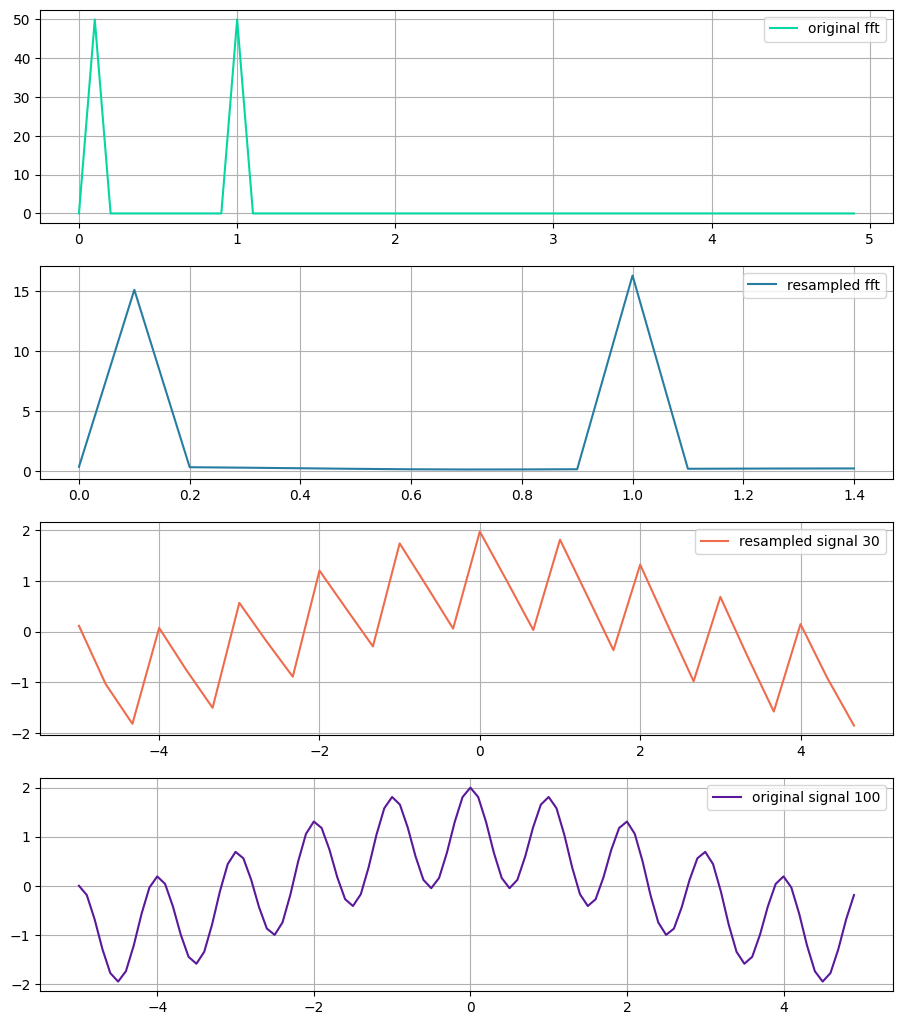

In [61]:
sampling = 0.1
x = np.arange(-xRange, xRange, sampling)
sampleRateConv(np.vectorize(np.cos)(np.pi*2*x)+np.vectorize(np.cos)(np.pi*0.2*x), 30)

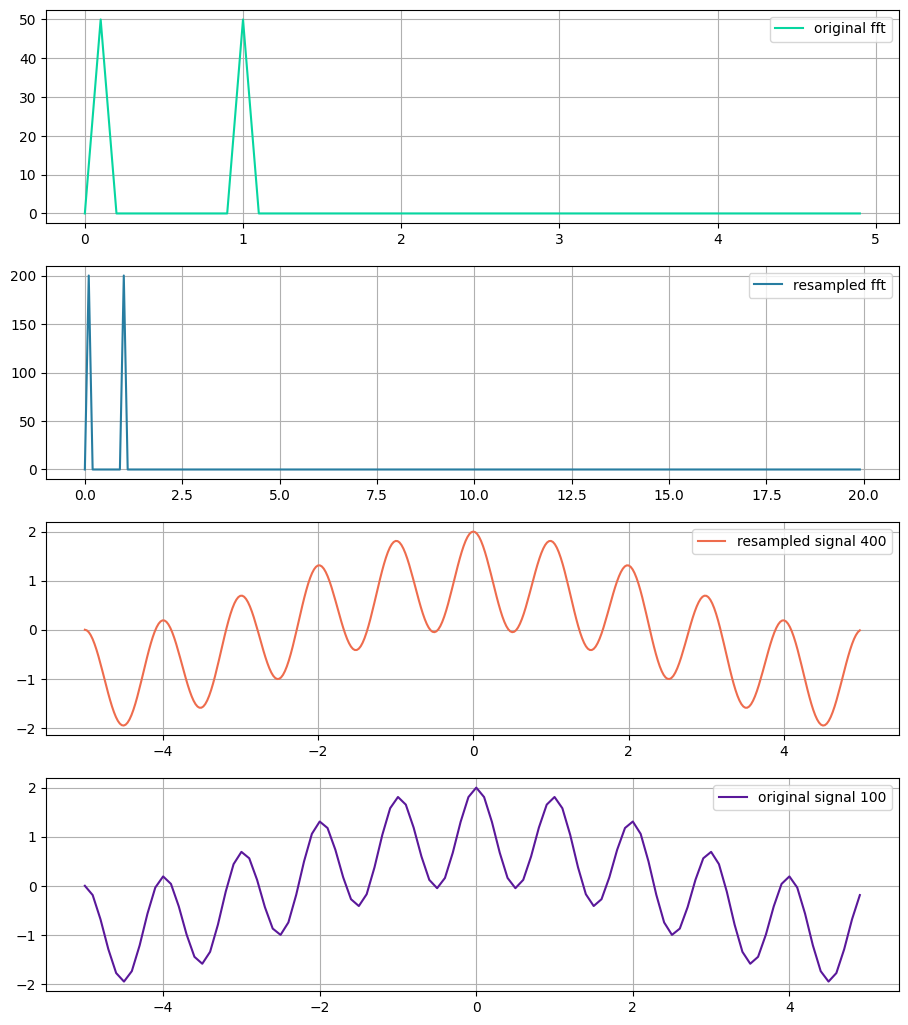

In [62]:
sampleRateConv(np.vectorize(np.cos)(np.pi*2*x)+np.vectorize(np.cos)(np.pi*0.2*x), 400)

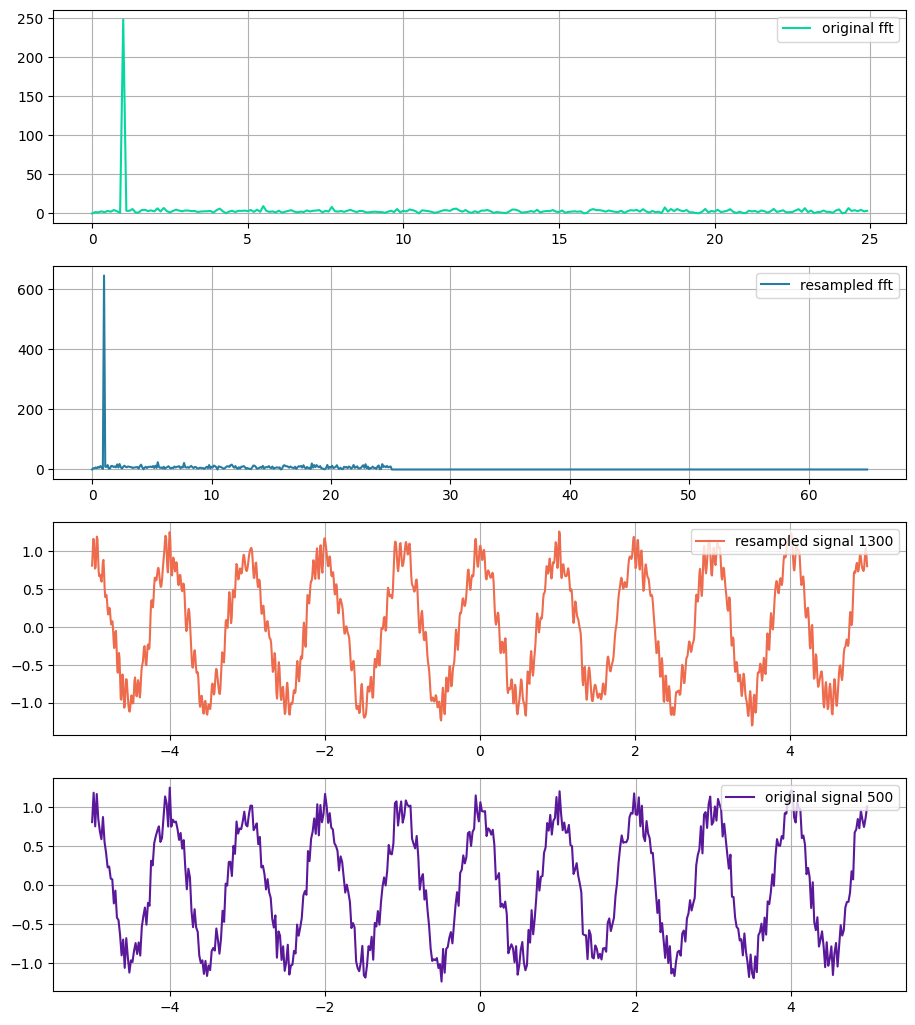

In [63]:
sampling = 0.02
x = np.arange(-xRange, xRange, sampling)

data = np.random.random(len(x))
data -= np.mean(data)
data = np.cos(2*np.pi*x) + data*0.5
sampleRateConv(data, 1300)

10.0 0.05


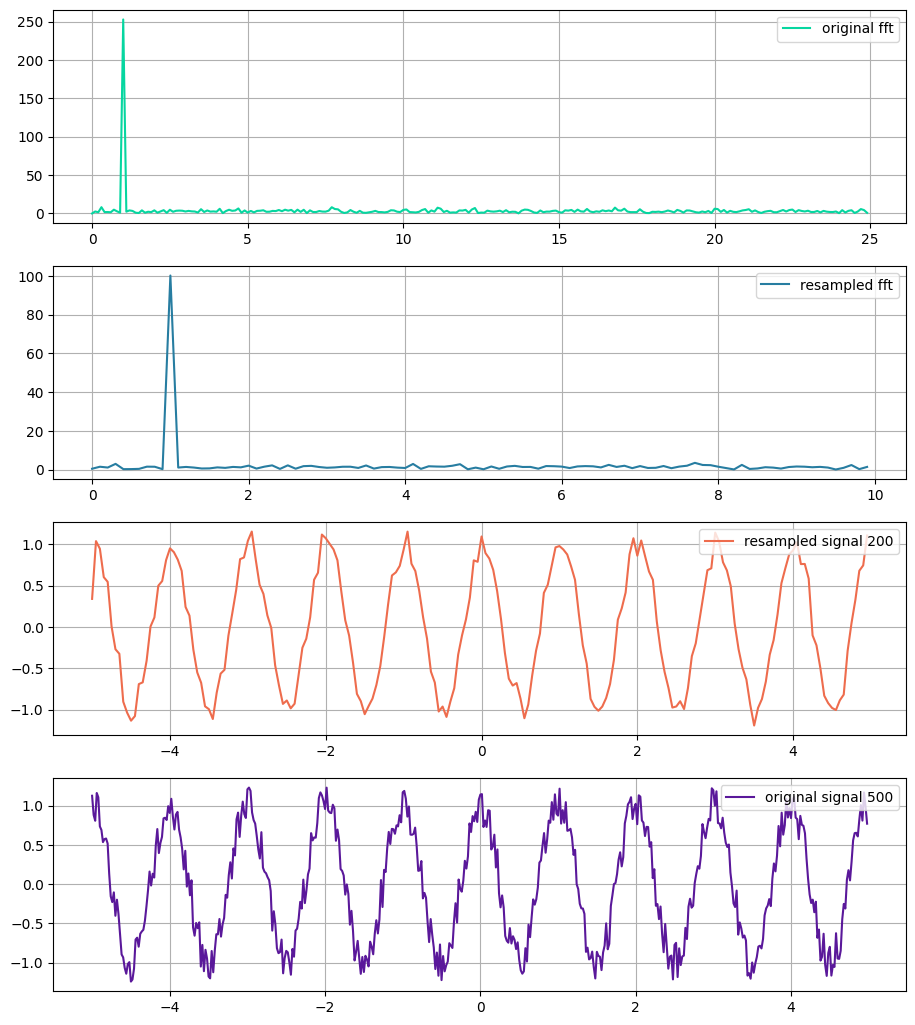

In [64]:
data = np.random.random(len(x))
data -= np.mean(data)
data = np.cos(2*np.pi*x) + data*0.5
sampleRateConv(data, 200)

10.0 0.05


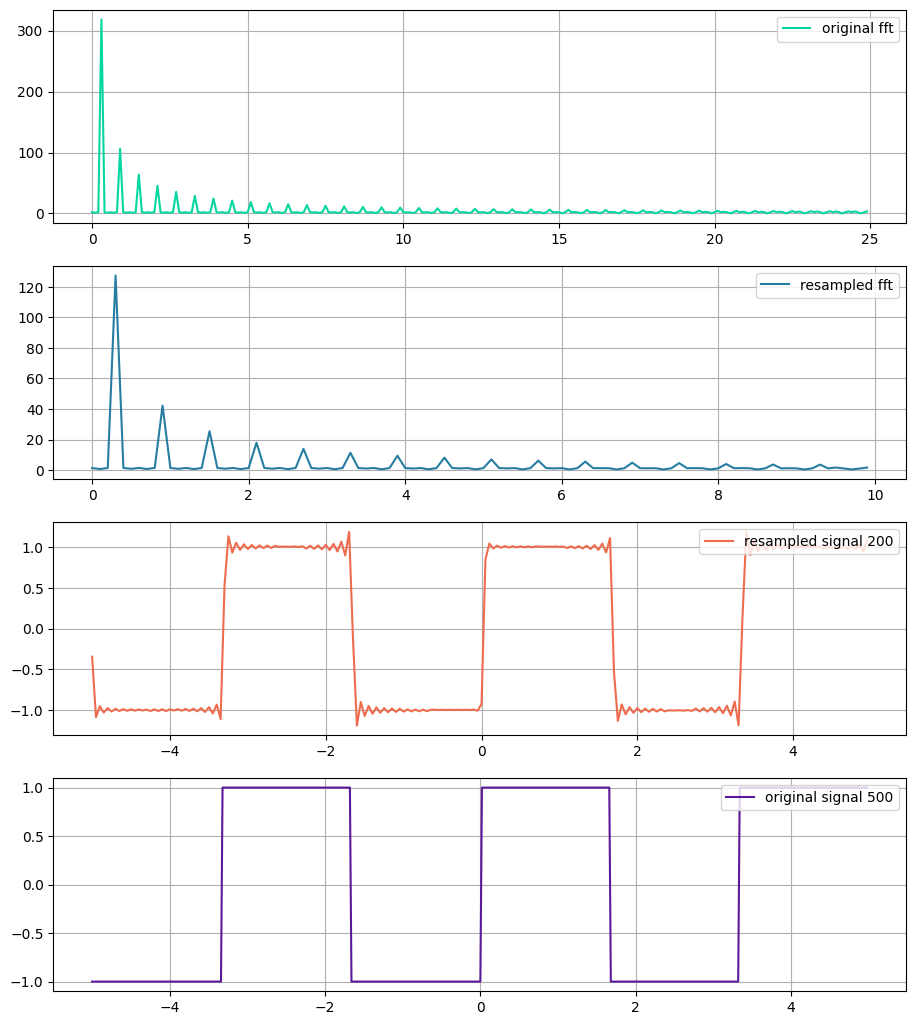

In [65]:
sampling = 0.02
x = np.arange(-xRange, xRange, sampling)

sampleRateConv(signal.square(2 * np.pi * 0.3 * x), 200)

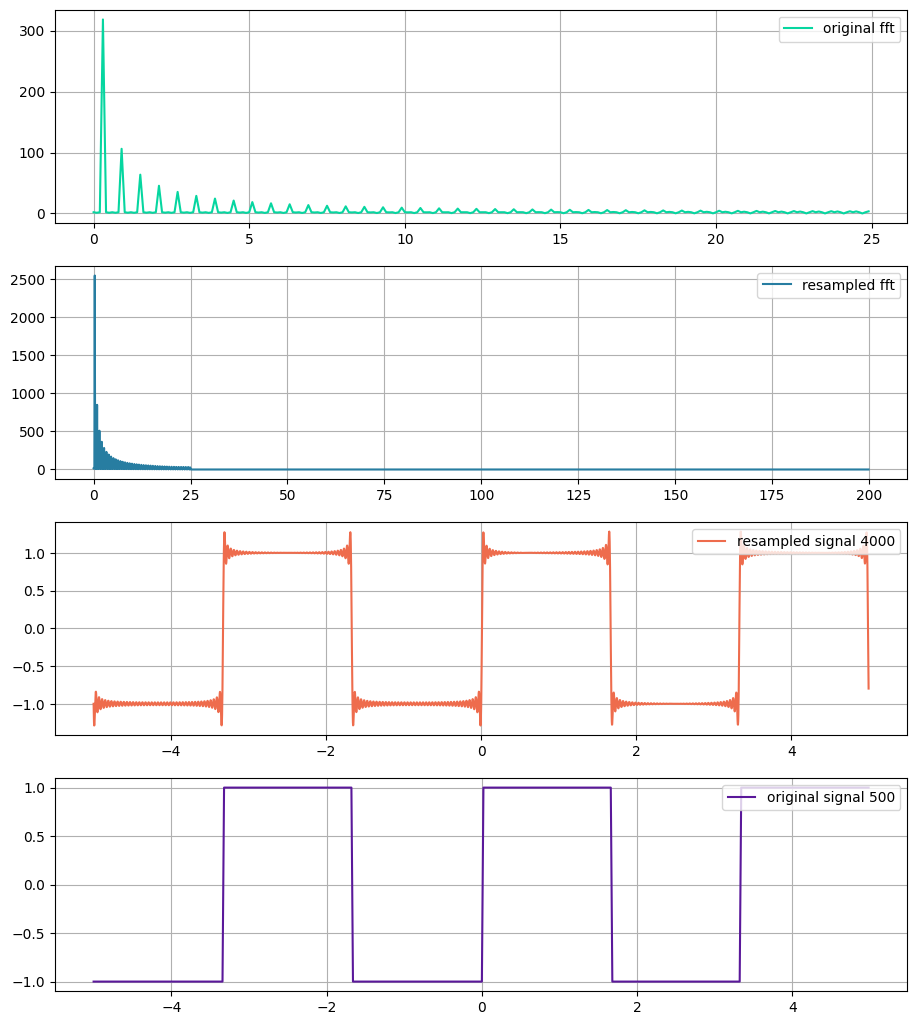

In [66]:
sampleRateConv(signal.square(2 * np.pi * 0.3 * x), 4000)

7.5 0.06666666666666667


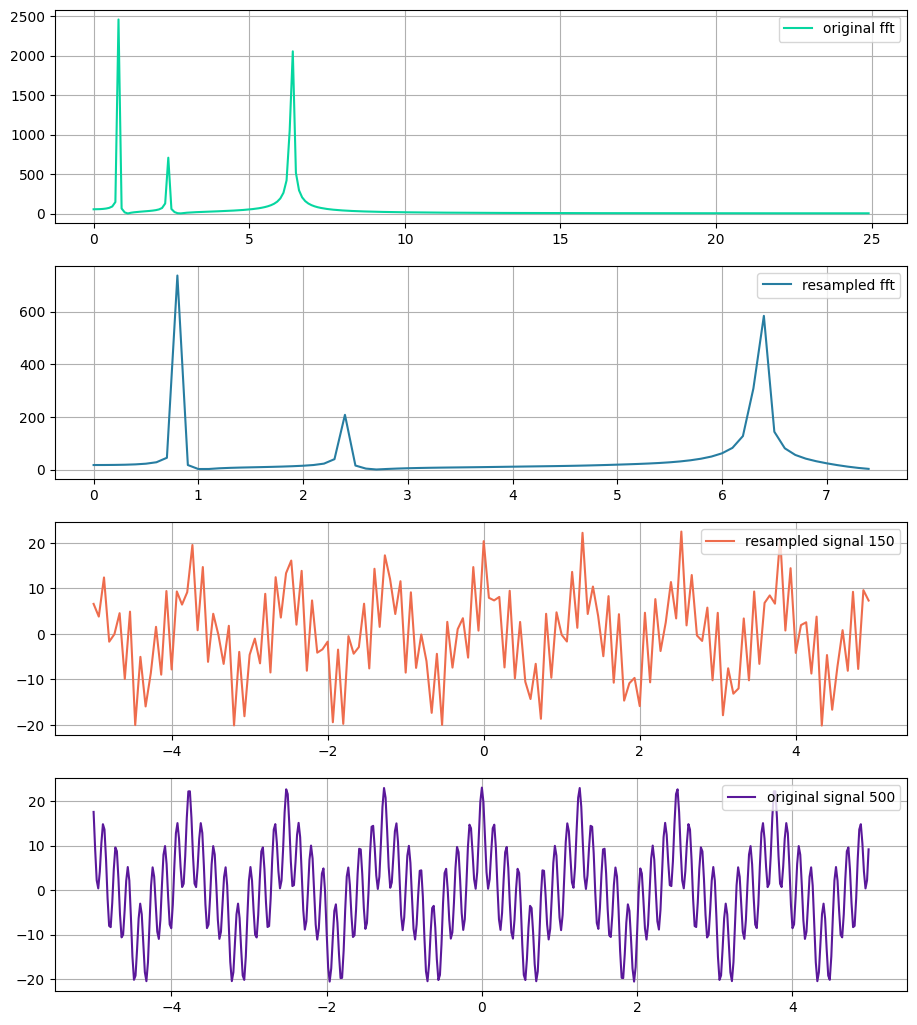

In [67]:
def testFunc1(x):
    return [10*np.cos(5*x[i])+3*np.cos(15*x[i])+10*np.cos(40*x[i]) for i in range(len(x))]
sampleRateConv(testFunc1(x), 150)

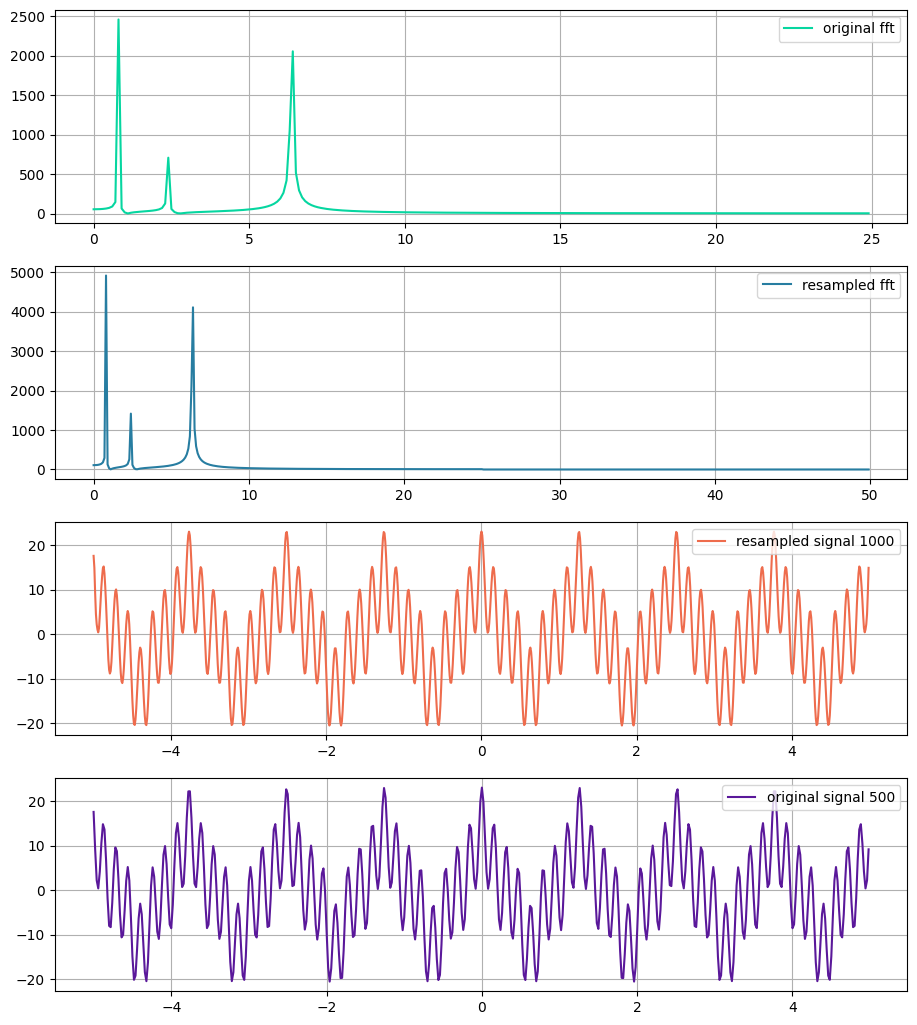

In [68]:
sampleRateConv(testFunc1(x), 1000)

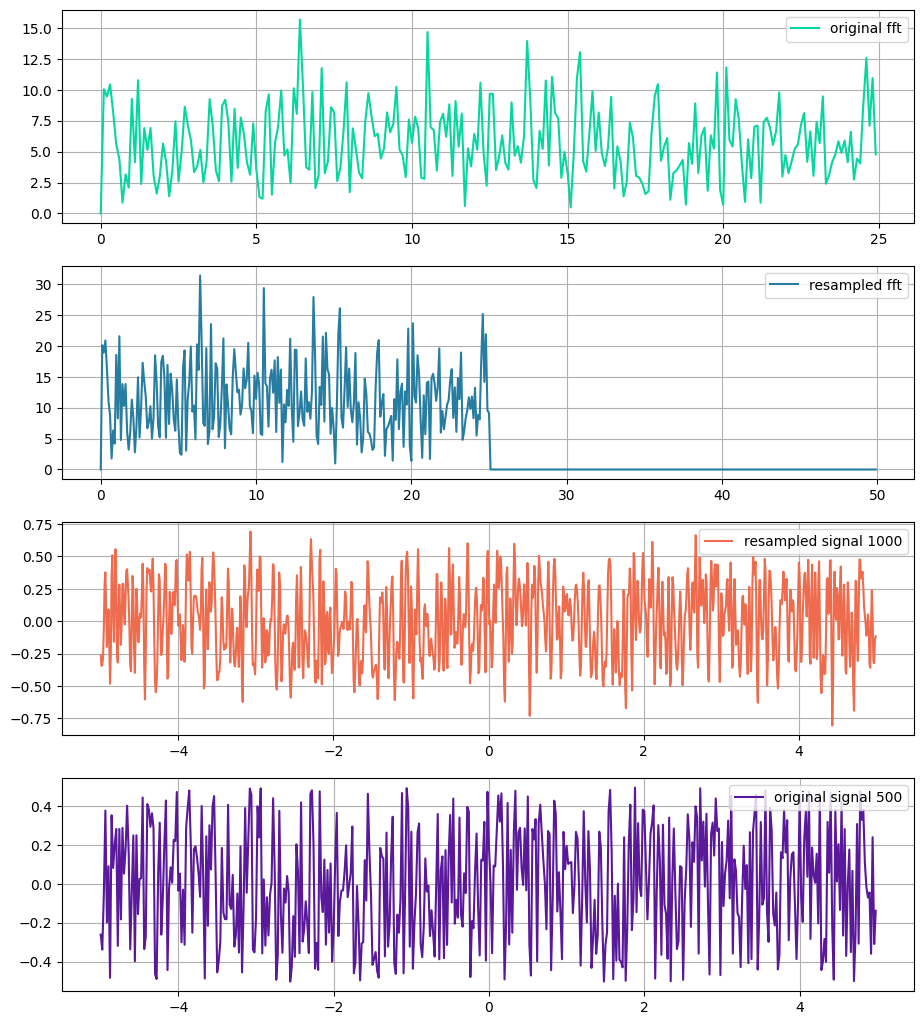

In [69]:
data = np.random.random(len(x))
data -= np.mean(data)
sampleRateConv(data, 1000)

10.0 0.05


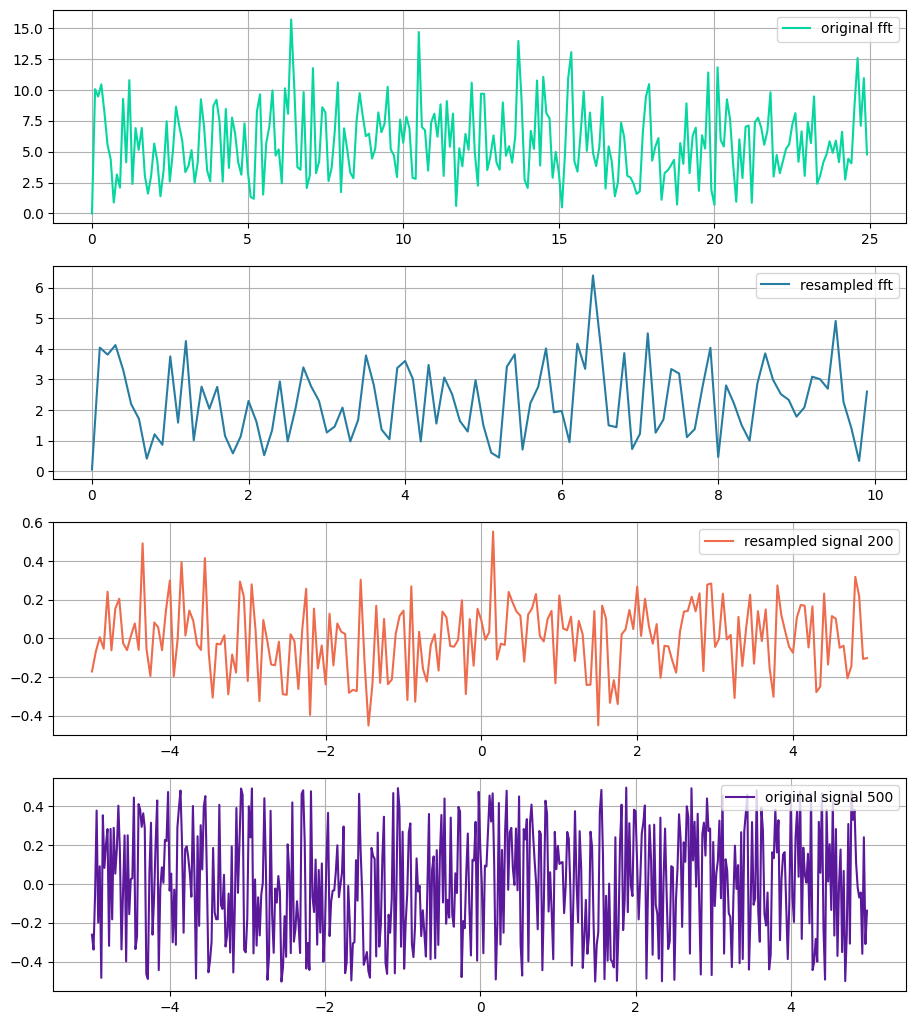

In [70]:
sampleRateConv(data, 200)